# Individual Neuron Correlation Analysis

This notebook processes individual neuron-to-neuron correlations for all layers.
Conv3 (1200×1200) is handled separately with optimized environment settings.

In [1]:
# Cell 0 - Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set paths
DATA_PATH = Path("../data/Merged zoo.csv")
FIG_DIR = Path("figures/09_correlations")
FIG_DIR.mkdir(exist_ok=True, parents=True)

# Load data
df = pd.read_csv(DATA_PATH)
print(f"Loaded data: {df.shape}")

Loaded data: (36468, 2483)


=== Individual Neuron Correlation Analysis ===
Processing all layers except conv3 (handled separately)...

Processing CONV1...
  200 neurons


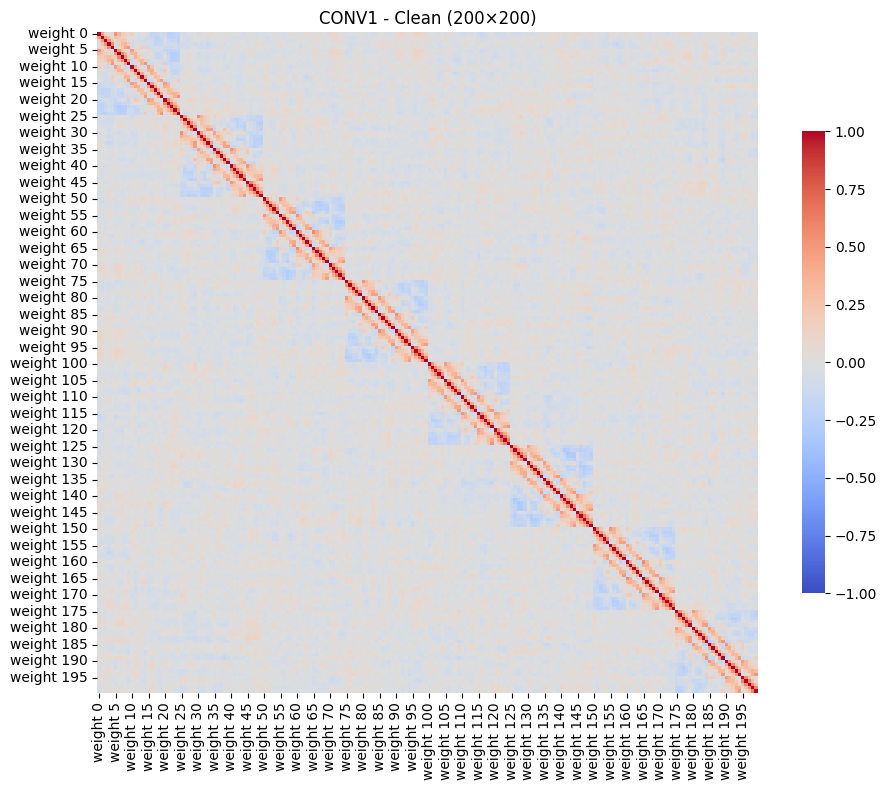

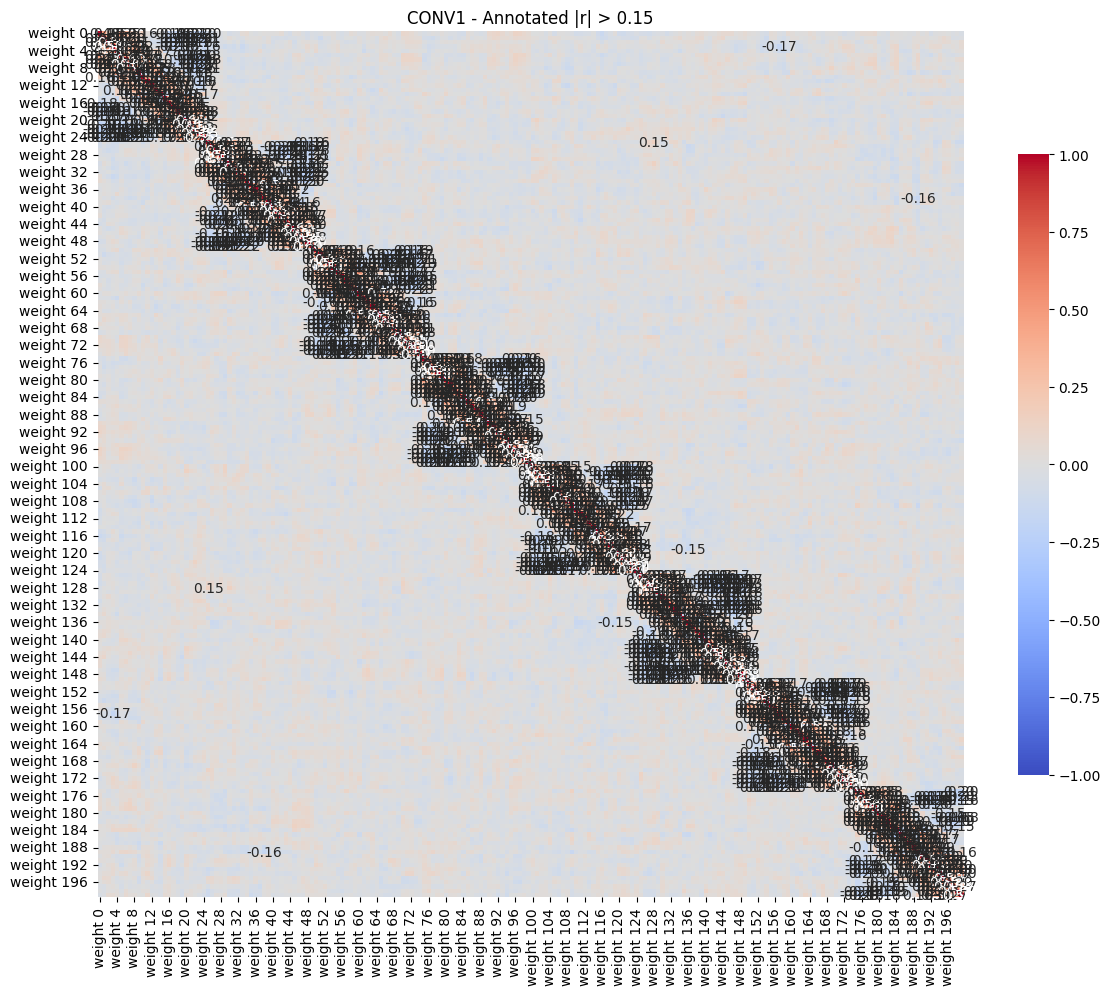

  ✓ conv1 completed

Processing FC1...
  716 neurons


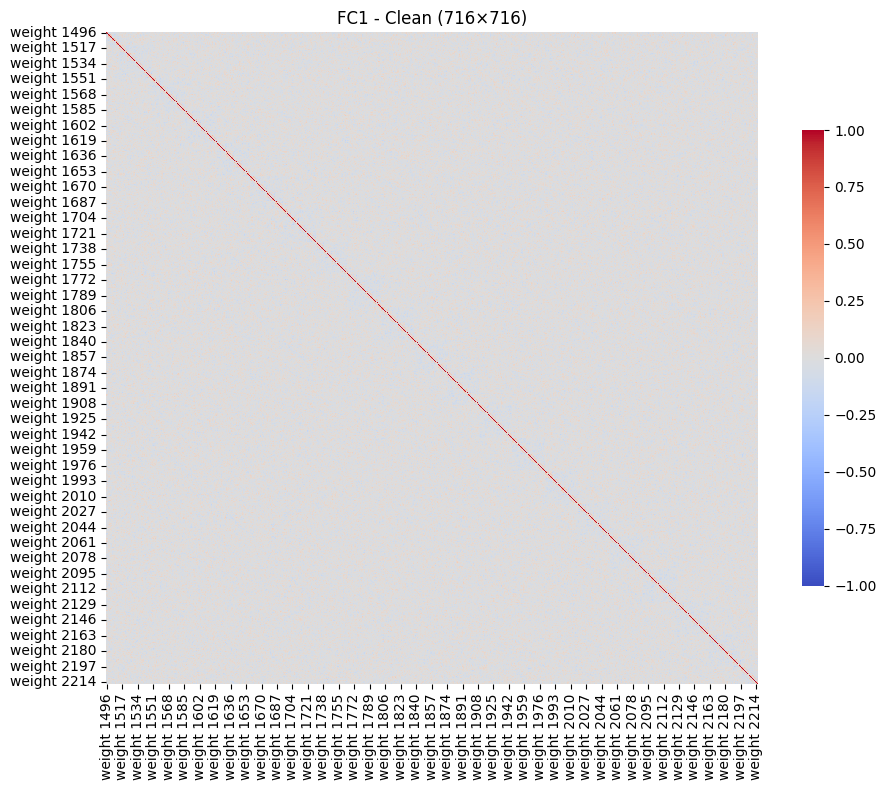

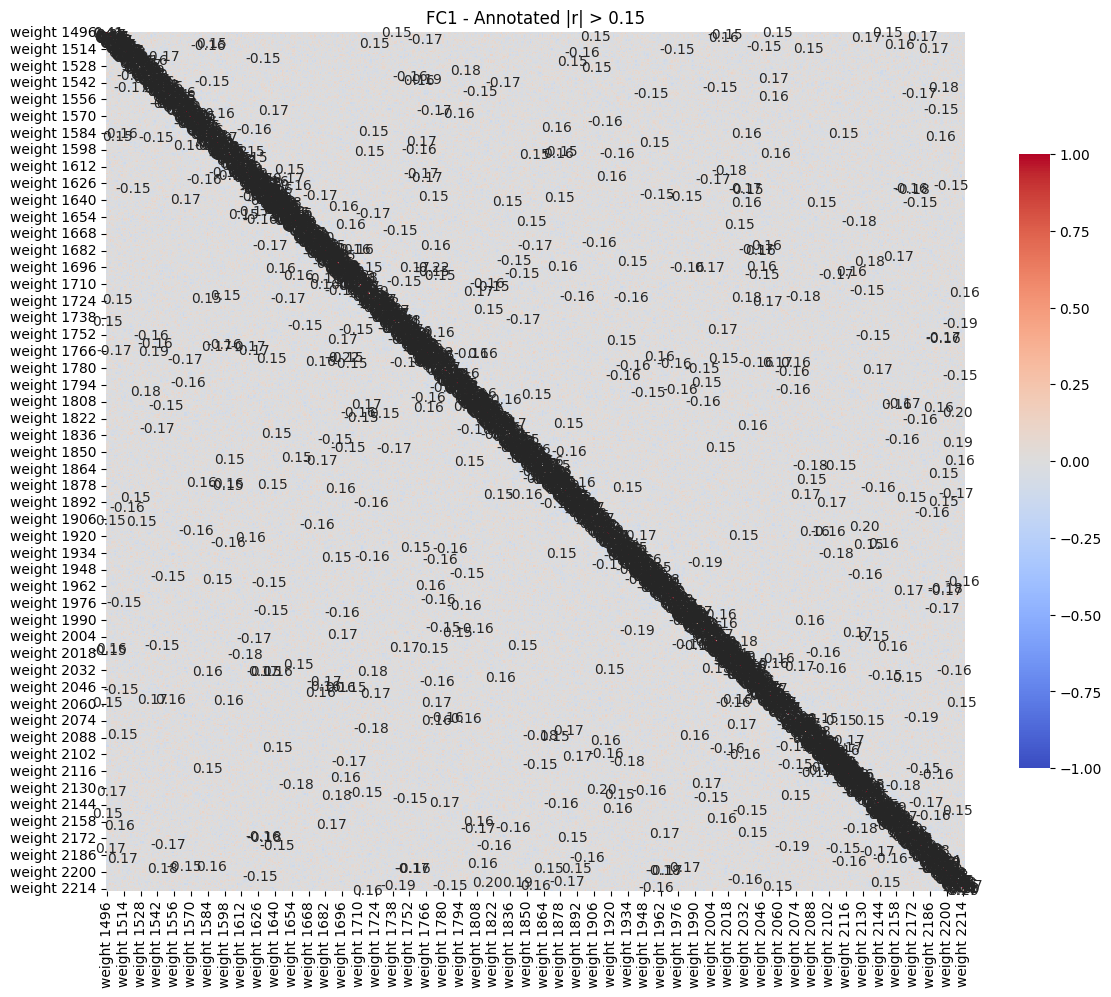

  ✓ fc1 completed

Processing FC2...
  190 neurons


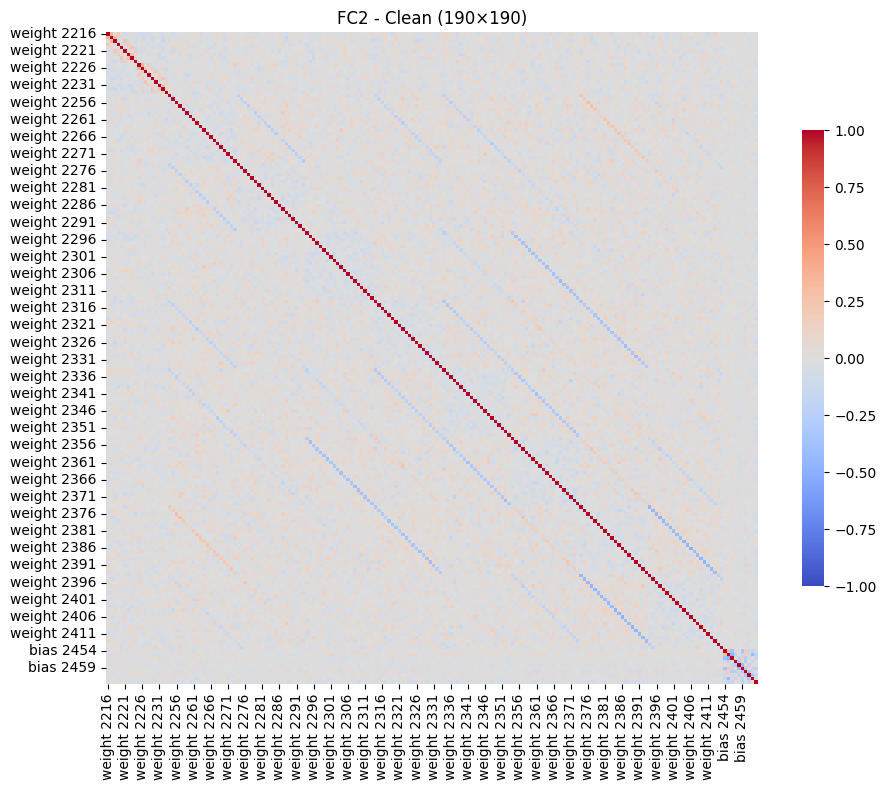

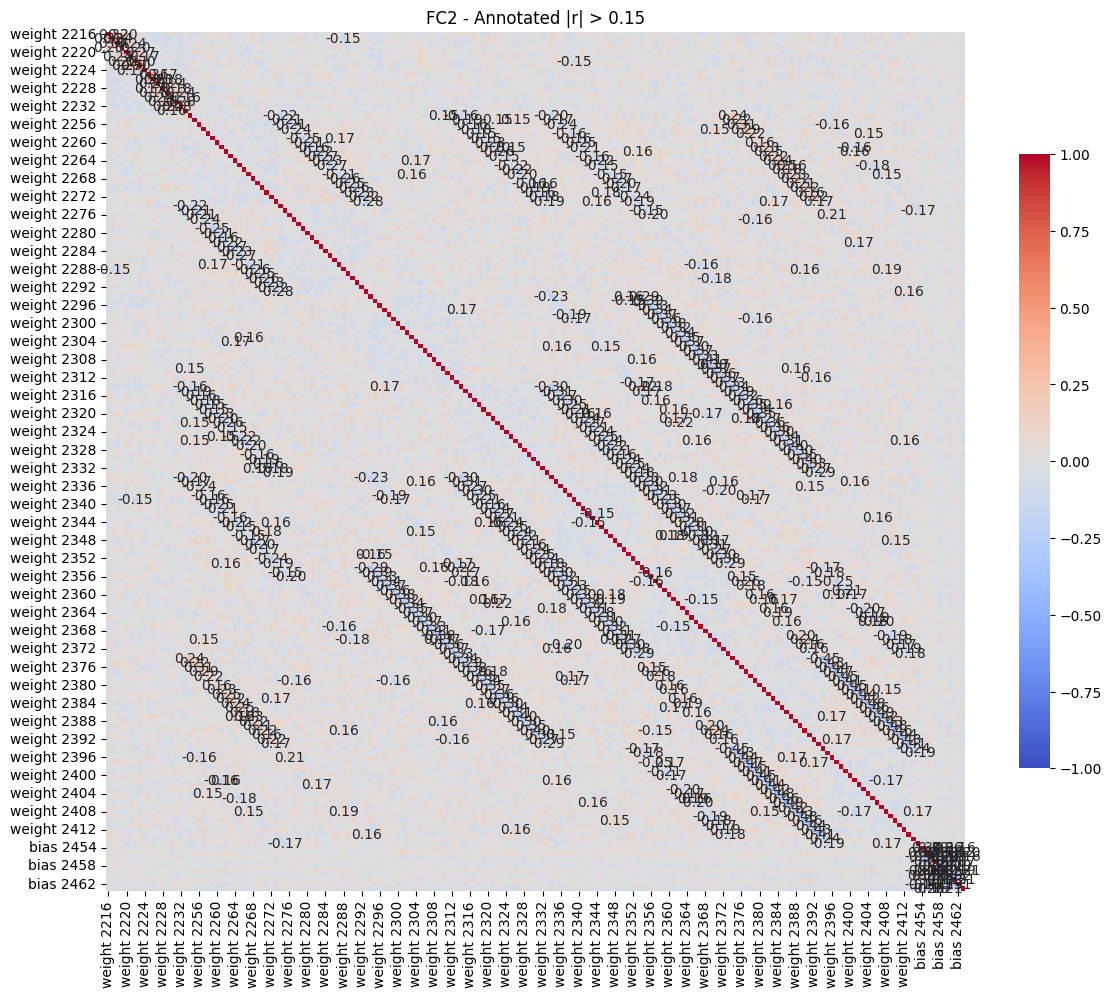

  ✓ fc2 completed

All layers (except conv3) processed successfully!


In [2]:
# Cell 1 - Individual Neuron Correlation (All Layers Except Conv3)
print("=== Individual Neuron Correlation Analysis ===")
print("Processing all layers except conv3 (handled separately)...\n")

def extract_neurons(df, layer_name, config):
    df_numeric = df.select_dtypes(include=[np.number])
    data, names = [], []
    
    if layer_name.startswith('conv'):
        start, end = config['weight_start'], config['weight_end']
        for j in range(start, end):
            col = f"weight {j}"
            if col in df_numeric.columns:
                data.append(df_numeric[col])
                f_idx = (j - start) // config['weights_per_filter']
                w_idx = (j - start) % config['weights_per_filter']
                names.append(f"F{f_idx}_W{w_idx}")
        # biases
        bias_start = config['bias_start'] + config['bias_offset']
        for i in range(config['n_biases']):
            col = f"bias {bias_start + i}"
            if col in df_numeric.columns:
                data.append(df_numeric[col])
                names.append(f"B{i}")
    else:
        start, end = config['weight_start'], config['weight_end']
        for j in range(start, end):
            col = f"weight {j}"
            if col in df_numeric.columns:
                data.append(df_numeric[col])
                n_idx = (j - start) // config['weights_per_neuron']
                i_idx = (j - start) % config['weights_per_neuron']
                names.append(f"N{n_idx}_I{i_idx}")
        # biases
        bias_start = config['bias_start'] + config['bias_offset']
        for i in range(config['n_biases']):
            col = f"bias {bias_start + i}"
            if col in df_numeric.columns:
                data.append(df_numeric[col])
                names.append(f"B{i}")
    
    return pd.DataFrame(data).T, names

# Layer configs
configs = {
    "conv1": {"weight_start": 0, "weight_end": 200, "weights_per_filter": 25, "bias_start": 2416, "bias_offset": 0, "n_biases": 8},
    "fc1": {"weight_start": 1496, "weight_end": 2216, "weights_per_neuron": 36, "bias_start": 2416, "bias_offset": 18, "n_biases": 20},
    "fc2": {"weight_start": 2216, "weight_end": 2416, "weights_per_neuron": 20, "bias_start": 2416, "bias_offset": 38, "n_biases": 10}
}

# Process layers
for layer_name in configs.keys():
    print(f"Processing {layer_name.upper()}...")
    
    try:
        neuron_df, names = extract_neurons(df, layer_name, configs[layer_name])
        n_neurons = len(names)
        print(f"  {n_neurons} neurons")
        
        # Sample
        sample_size = min(1500, len(neuron_df))
        if len(neuron_df) > sample_size:
            neuron_df = neuron_df.sample(n=sample_size, random_state=42)
        
        # Correlation
        corr = neuron_df.corr()
        corr.to_csv(FIG_DIR / f"{layer_name}_correlation.csv")
        
        # Plot 1: Clean
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.heatmap(corr, annot=False, cmap="coolwarm", center=0, 
                   vmin=-1, vmax=1, square=True, cbar_kws={"shrink": 0.7}, ax=ax)
        ax.set_title(f"{layer_name.upper()} - Clean ({n_neurons}×{n_neurons})")
        plt.tight_layout()
        plt.savefig(FIG_DIR / f"{layer_name}_clean.png", dpi=300)
        plt.show()
        plt.close(fig)
        
        # Plot 2: Annotated
        fig, ax = plt.subplots(figsize=(12, 10))
        annot = np.full_like(corr, '', dtype=object)
        for i in range(n_neurons):
            for j in range(n_neurons):
                if i != j and abs(corr.iloc[i, j]) > 0.15:
                    annot[i, j] = f"{corr.iloc[i, j]:.2f}"
        
        sns.heatmap(corr, annot=annot, fmt='', cmap="coolwarm", center=0,
                   vmin=-1, vmax=1, square=True, cbar_kws={"shrink": 0.7}, ax=ax)
        ax.set_title(f"{layer_name.upper()} - Annotated |r| > 0.15")
        plt.tight_layout()
        plt.savefig(FIG_DIR / f"{layer_name}_annotated.png", dpi=300)
        plt.show()
        plt.close(fig)
        
        import gc; gc.collect()
        print(f"  ✓ {layer_name} completed\n")
        
    except Exception as e:
        print(f"  ✗ Error: {e}\n")
        plt.close('all')
        continue

print("All layers (except conv3) processed successfully!")

=== Conv3 Processing with Optimized Environment ===
Setting environment variables for high-memory processing...

Environment optimized:
  OMP_NUM_THREADS: 8
  MKL_NUM_THREADS: 8
  Available memory optimization enabled

Processing CONV3 (1200×1200 matrix)...
Conv3: 90 individual neurons/connections
Using reduced sample of 1000 models for conv3
Computing conv3 correlation matrix (this may take a moment)...
Conv3 correlation statistics:
  Strong correlations (|r| > 0.5): 2 pairs
  Moderate correlations (0.15 < |r| ≤ 0.5): 146 pairs
  Total significant (>0.15): 148 pairs
Saved correlation matrix: figures/09_correlations/conv3_individual_neuron_correlation.csv

Creating conv3 clean heatmap...
Saved conv3 clean heatmap: figures/09_correlations/conv3_clean_correlation.png


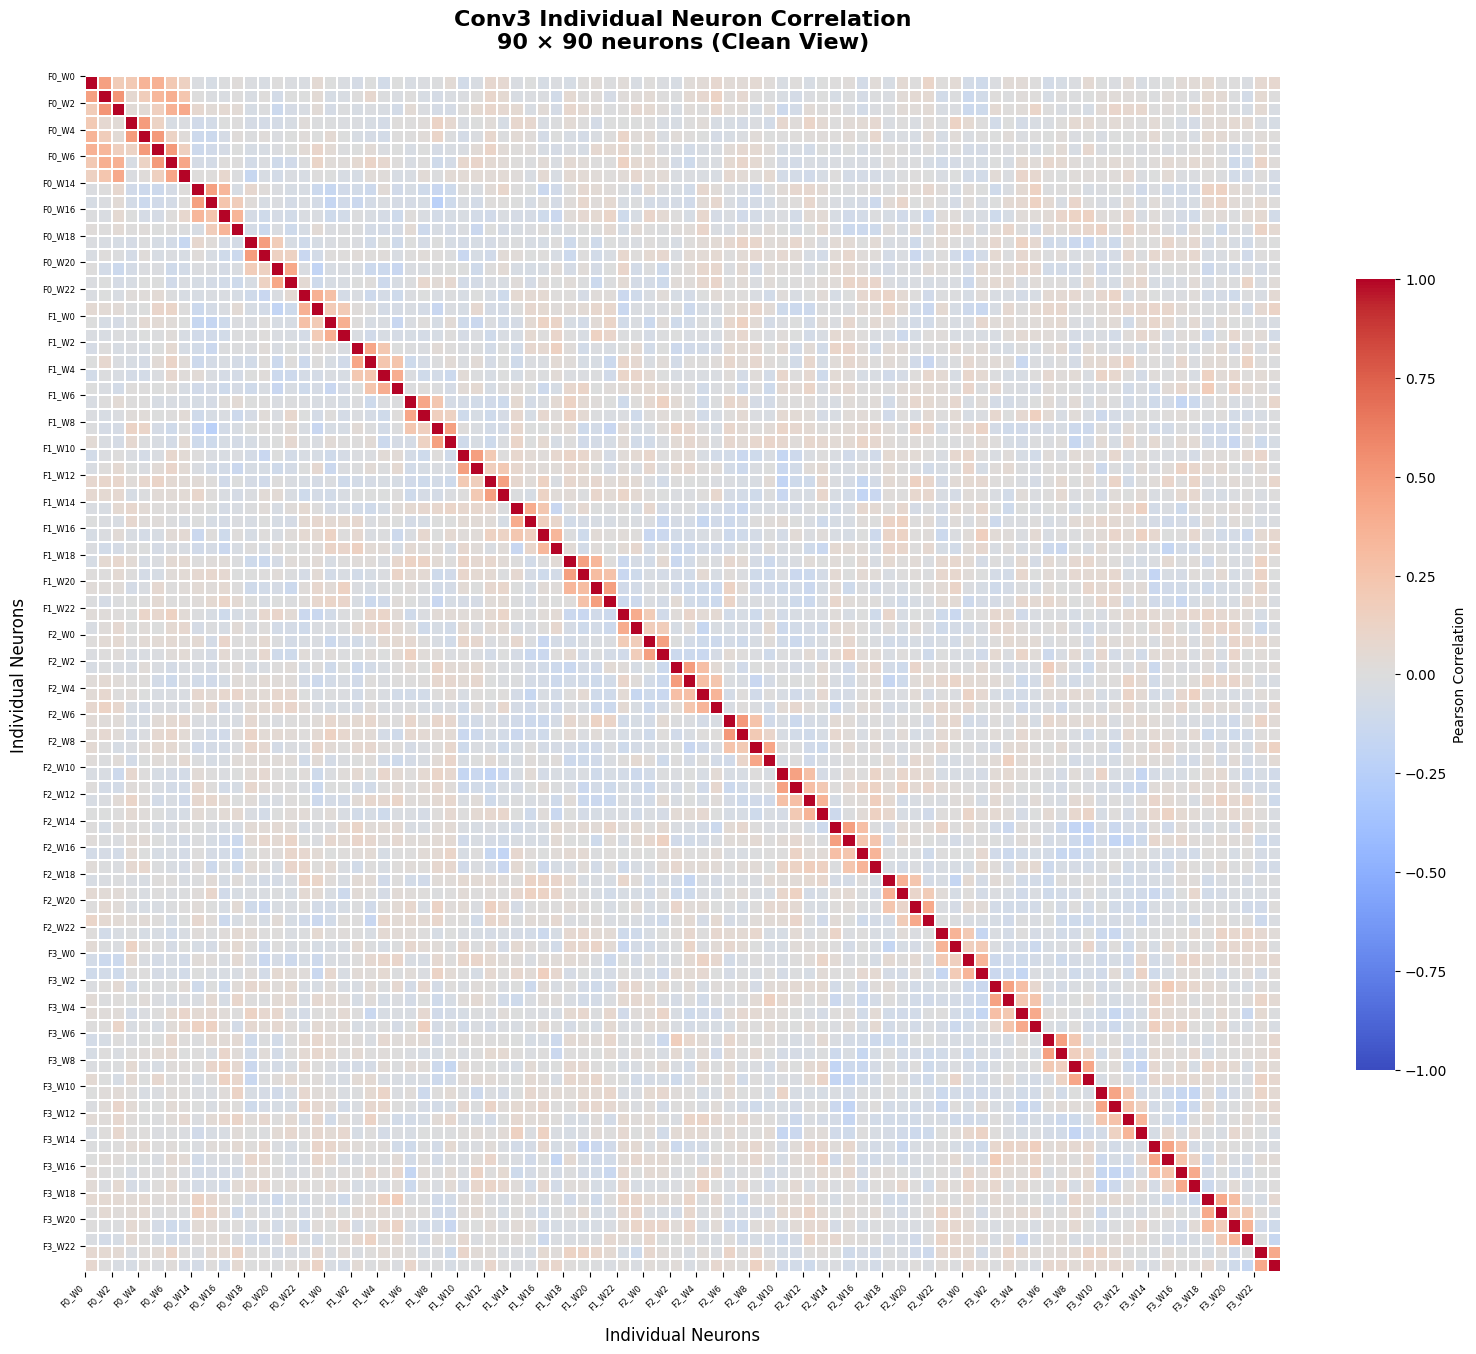

Conv3 clean heatmap figure closed to free memory

Creating conv3 annotated heatmap...
Saved conv3 annotated heatmap: figures/09_correlations/conv3_annotated_correlation.png


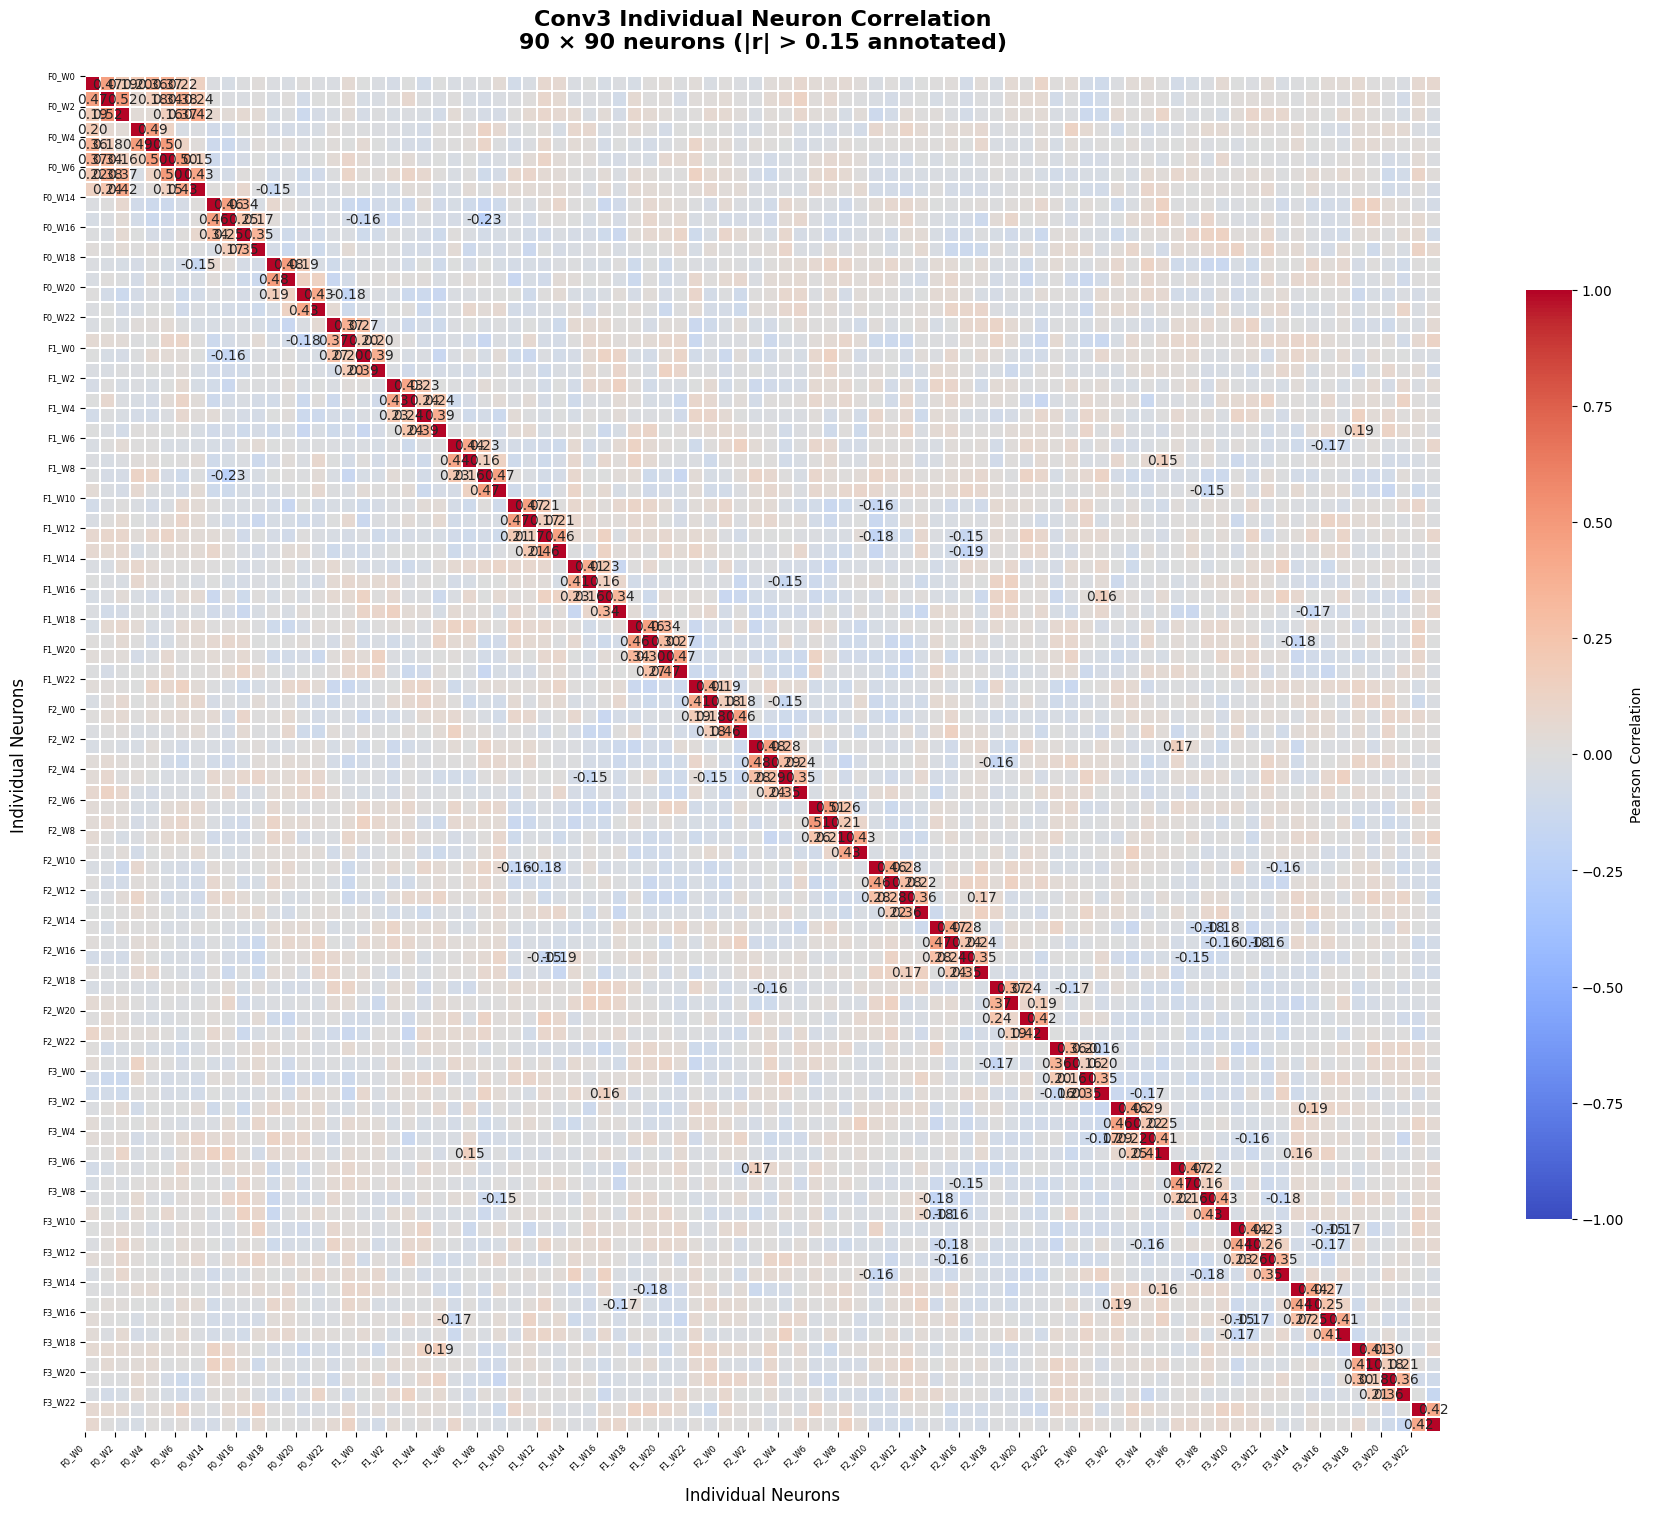

Conv3 annotated heatmap figure closed to free memory

✓ CONV3 completed successfully!
  Matrix size: 90×90
  Significant correlations: 148 pairs

INDIVIDUAL NEURON CORRELATION ANALYSIS COMPLETE
Generated for each layer:
• Clean heatmap with colors only (no annotations)
• Annotated heatmap with |r| > 0.15 values shown
• CSV file with complete correlation matrix
• Conv3 processed with optimized environment settings


In [3]:
# Cell 2 - Conv3 Processing with Optimized Environment
print("=== Conv3 Processing with Optimized Environment ===")
print("Setting environment variables for high-memory processing...\n")

# Optimize environment for large matrix operations
import os
os.environ['OMP_NUM_THREADS'] = '8'  # Limit OpenMP threads
os.environ['MKL_NUM_THREADS'] = '8'  # Limit MKL threads
os.environ['NUMEXPR_NUM_THREADS'] = '8'  # Limit numexpr threads
os.environ['VECLIB_MAXIMUM_THREADS'] = '8'  # Limit Accelerate threads

# Set matplotlib to use less memory
plt.rcParams['figure.max_open_warning'] = 50
plt.rcParams['agg.path.chunksize'] = 10000

print("Environment optimized:")
print(f"  OMP_NUM_THREADS: {os.environ.get('OMP_NUM_THREADS')}")
print(f"  MKL_NUM_THREADS: {os.environ.get('MKL_NUM_THREADS')}")
print(f"  Available memory optimization enabled\n")

# Conv3 configuration
conv3_config = {
    "weight_start": 1400, "weight_end": 1496, 
    "weights_per_filter": 24, "bias_start": 2416, 
    "bias_offset": 14, "n_biases": 4
}

print("Processing CONV3 (1200×1200 matrix)...")

try:
    # Extract conv3 neurons
    neuron_df, names = extract_neurons(df, "conv3", conv3_config)
    n_neurons = len(names)
    print(f"Conv3: {n_neurons} individual neurons/connections")
    
    # Use smaller sample for conv3 due to size
    sample_size = min(1000, len(neuron_df))
    if len(neuron_df) > sample_size:
        neuron_df = neuron_df.sample(n=sample_size, random_state=42)
        print(f"Using reduced sample of {sample_size} models for conv3")
    
    print("Computing conv3 correlation matrix (this may take a moment)...")
    corr_matrix = neuron_df.corr(method='pearson')
    
    # Compute statistics
    corr_values = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]
    strong_corr = np.sum(np.abs(corr_values) > 0.5)
    moderate_corr = np.sum((np.abs(corr_values) > 0.15) & (np.abs(corr_values) <= 0.5))
    
    print(f"Conv3 correlation statistics:")
    print(f"  Strong correlations (|r| > 0.5): {strong_corr} pairs")
    print(f"  Moderate correlations (0.15 < |r| ≤ 0.5): {moderate_corr} pairs")
    print(f"  Total significant (>0.15): {strong_corr + moderate_corr} pairs")
    
    # Save correlation matrix
    csv_path = FIG_DIR / "conv3_individual_neuron_correlation.csv"
    corr_matrix.to_csv(csv_path)
    print(f"Saved correlation matrix: {csv_path}")
    
    # PLOT 1: Clean heatmap (larger figsize for conv3)
    print("\nCreating conv3 clean heatmap...")
    fig1, ax1 = plt.subplots(figsize=(16, 14))
    
    sns.heatmap(corr_matrix, annot=False, cmap="coolwarm",
                center=0, vmin=-1, vmax=1, square=True, linewidths=0.2,
                cbar_kws={"shrink": 0.6, "label": "Pearson Correlation"}, ax=ax1)
    
    ax1.set_title(f"Conv3 Individual Neuron Correlation\n" + 
                 f"{n_neurons} × {n_neurons} neurons (Clean View)",
                 fontsize=16, fontweight="bold", pad=20)
    
    # Reduce tick labels for readability
    step = max(1, n_neurons // 40)
    tick_positions = list(range(0, n_neurons, step))
    ax1.set_xticks(tick_positions)
    ax1.set_yticks(tick_positions)
    ax1.set_xticklabels([names[i] for i in tick_positions], 
                       rotation=45, ha='right', fontsize=6)
    ax1.set_yticklabels([names[i] for i in tick_positions], 
                       rotation=0, fontsize=6)
    
    ax1.set_xlabel("Individual Neurons", fontsize=12, labelpad=10)
    ax1.set_ylabel("Individual Neurons", fontsize=12, labelpad=10)
    
    plt.tight_layout()
    clean_path = FIG_DIR / "conv3_clean_correlation.png"
    fig1.savefig(clean_path, dpi=250, bbox_inches="tight")
    print(f"Saved conv3 clean heatmap: {clean_path}")
    plt.show()
    plt.close(fig1)
    print("Conv3 clean heatmap figure closed to free memory")
    
    # Force garbage collection before creating second plot
    import gc
    gc.collect()
    
    # PLOT 2: Annotated heatmap (only significant correlations)
    print("\nCreating conv3 annotated heatmap...")
    fig2, ax2 = plt.subplots(figsize=(18, 16))
    
    # Create annotation matrix (only significant correlations)
    annot_matrix = np.full_like(corr_matrix, '', dtype=object)
    for i in range(n_neurons):
        for j in range(n_neurons):
            if i != j and abs(corr_matrix.iloc[i, j]) > 0.15:
                annot_matrix[i, j] = f"{corr_matrix.iloc[i, j]:.2f}"
    
    sns.heatmap(corr_matrix, annot=annot_matrix, fmt='', cmap="coolwarm",
                center=0, vmin=-1, vmax=1, square=True, linewidths=0.2,
                cbar_kws={"shrink": 0.6, "label": "Pearson Correlation"}, ax=ax2)
    
    ax2.set_title(f"Conv3 Individual Neuron Correlation\n" + 
                 f"{n_neurons} × {n_neurons} neurons (|r| > 0.15 annotated)",
                 fontsize=16, fontweight="bold", pad=20)
    
    # Reduce tick labels
    ax2.set_xticks(tick_positions)
    ax2.set_yticks(tick_positions)
    ax2.set_xticklabels([names[i] for i in tick_positions], 
                       rotation=45, ha='right', fontsize=6)
    ax2.set_yticklabels([names[i] for i in tick_positions], 
                       rotation=0, fontsize=6)
    
    ax2.set_xlabel("Individual Neurons", fontsize=12, labelpad=10)
    ax2.set_ylabel("Individual Neurons", fontsize=12, labelpad=10)
    
    plt.tight_layout()
    annotated_path = FIG_DIR / "conv3_annotated_correlation.png"
    fig2.savefig(annotated_path, dpi=250, bbox_inches="tight")
    print(f"Saved conv3 annotated heatmap: {annotated_path}")
    plt.show()
    plt.close(fig2)
    print("Conv3 annotated heatmap figure closed to free memory")
    
    # Final garbage collection
    gc.collect()
    
    print(f"\n✓ CONV3 completed successfully!")
    print(f"  Matrix size: {n_neurons}×{n_neurons}")
    print(f"  Significant correlations: {strong_corr + moderate_corr} pairs")
    
except Exception as e:
    print(f"✗ Error processing conv3: {str(e)}")
    plt.close('all')
    import gc
    gc.collect()

print(f"\n{'='*60}")
print("INDIVIDUAL NEURON CORRELATION ANALYSIS COMPLETE")
print(f"{'='*60}")
print("Generated for each layer:")
print("• Clean heatmap with colors only (no annotations)")
print("• Annotated heatmap with |r| > 0.15 values shown")
print("• CSV file with complete correlation matrix")
print("• Conv3 processed with optimized environment settings")